In [1]:
!pip install alive_progress

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 3.5 MB/s eta 0:00:00
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210082 sha256=4a4995def64901fc43c8a58b63792bce1f325f411474ca138fc1db1b22f0ea67
  Stored in directory: /root/.cache/pip/wheels/ee/3b/0b/1b865800e916d671a24028d884698674138632a83fdfad4926
Successfully built grapheme


# Import Essential Libraries

In [39]:
import sys, os
import pandas as pd
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.models import model_from_json
import tensorflow as tf
from tensorflow.python.framework import type_spec

# Mount Google Drive

First let's mount Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Make sure that we are using a GPU for tensorflow

In [5]:
import tensorflow as tf

# detect whether or not GPU is available
tf.test.gpu_device_name()

'/device:GPU:0'

# Part 1: Facial Expression Recognition

## Preprocessing
Using the built FER2013 model
Reference:
1. Facial Emotion Recognition on FER2013 Dataset Using a Convolutional Neural Network
https://github.com/gitshanks/fer2013
2. Kaggle challenge (FER-2013): https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

pathname = '/content/drive/MyDrive/FIT3162/deep-lie/fer2013/'
data = pd.read_csv(pathname+'fer2013.csv')

width, height = 48, 48

In [ ]:
datapoints = data['pixels'].tolist()

# getting features for training
X = []
for xseq in datapoints:
    xx = [int(xp) for xp in xseq.split(' ')]
    xx = np.asarray(xx).reshape(width, height)
    X.append(xx.astype('float32'))

X = np.asarray(X)
X = np.expand_dims(X, -1)

# getting labels for training
y = pd.get_dummies(data['emotion']).values

print(f"X.shape={X.shape}, y.shape={y.shape}")
# storing them using numpy
np.save(pathname+'fdataX', X)
np.save(pathname+'flabels', y)

print("Preprocessing Done")
print("Number of Features: "+str(len(X[0])))
print("Number of Labels: " + str(len(y[0])))
print("Number of examples in dataset:"+str(len(X)))
print("X,y stored in fdataX.npy and flabels.npy respectively")


X.shape=(35887, 48, 48, 1), y.shape=(35887, 7)
Preprocessing Done
Number of Features: 48
Number of Labels: 7
Number of examples in dataset:35887
X,y stored in fdataX.npy and flabels.npy respectively


In [ ]:
import cv2
from google.colab.patches import cv2_imshow

def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

def get_face_from_image(img):
  # resized_image = image_resize(img, width=1000)
  gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
  face = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  faces = face.detectMultiScale(gray, 1.2, 5)
  return (True, faces[0]) if len(faces)>0 else (False, None)

## Train FER
We do not necessarily need to train a new one. Just use the existing parameters for now. This section is useful for identifying the ConvNet structure used to train the model.

Reference: Facial Emotion Recognition on FER2013 Dataset Using a Convolutional Neural Network
https://github.com/gitshanks/fer2013

In [ ]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
width, height = 48, 48

x = np.load(pathname+'fdataX.npy')
y = np.load(pathname+'flabels.npy')

x -= np.mean(x, axis=0)
x /= np.std(x, axis=0)

#splitting into training, validation and testing data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

#saving the test samples to be used later
np.save(pathname+'modXtest', X_test)
np.save(pathname+'modytest', y_test)

#desinging the CNN
def create_model(n_hidden_conv_layers = 3):
  model = Sequential()

  model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
  model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  for i in range(n_hidden_conv_layers):
    model.add(Conv2D(2**(i+1)*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(2**(i+1)*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(2*2*2*num_features, activation='relu'))
  model.add(Dropout(0.4)) #0.4
  model.add(Dense(2*2*num_features, activation='relu'))
  model.add(Dropout(0.4)) #0.4
  model.add(Dense(2*num_features, activation='relu'))
  model.add(Dropout(0.5)) #0.5

  model.add(Dense(num_labels, activation='softmax'))
  return model

# with strategy.scope():
model = create_model()
#Compliling the model with adam optimixer and categorical crossentropy loss
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
              metrics=['accuracy'])



In [ ]:
#training the model
model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_valid), np.array(y_valid)),
          shuffle=True)

#saving the  model to be used later
fer_json = model.to_json()
with open(pathname+"fer.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights(pathname+"fer.weights.h5")
print("Saved model to disk")

Epoch 1/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 1493s 3s/step - accuracy: 0.1977 - loss: 2.3293 - val_accuracy: 0.2594 - val_loss: 1.8249
Epoch 2/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 1536s 3s/step - accuracy: 0.2597 - loss: 1.8015 - val_accuracy: 0.3198 - val_loss: 1.6704
Epoch 3/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 1519s 3s/step - accuracy: 0.3045 - loss: 1.7225 - val_accuracy: 0.3498 - val_loss: 1.5769
Epoch 4/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 1526s 3s/step - accuracy: 0.3639 - loss: 1.6124 - val_accuracy: 0.4043 - val_loss: 1.5047
Epoch 5/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 1522s 3s/step - accuracy: 0.4082 - loss: 1.5085 - val_accuracy: 0.4334 - val_loss: 1.4185
Epoch 6/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 1503s 3s/step - accuracy: 0.4378 - loss: 1.4463 - val_accuracy: 0.4644 - val_loss: 1.3585
Epoch 7/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 1521s 3s/step - accuracy: 0.4496 - loss: 1.4131 - val_accuracy: 0.4929 - val_loss: 1.3564
Epoch 8/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 1501s 3s/step - accuracy: 0.4654 - loss: 1

**Model Output**
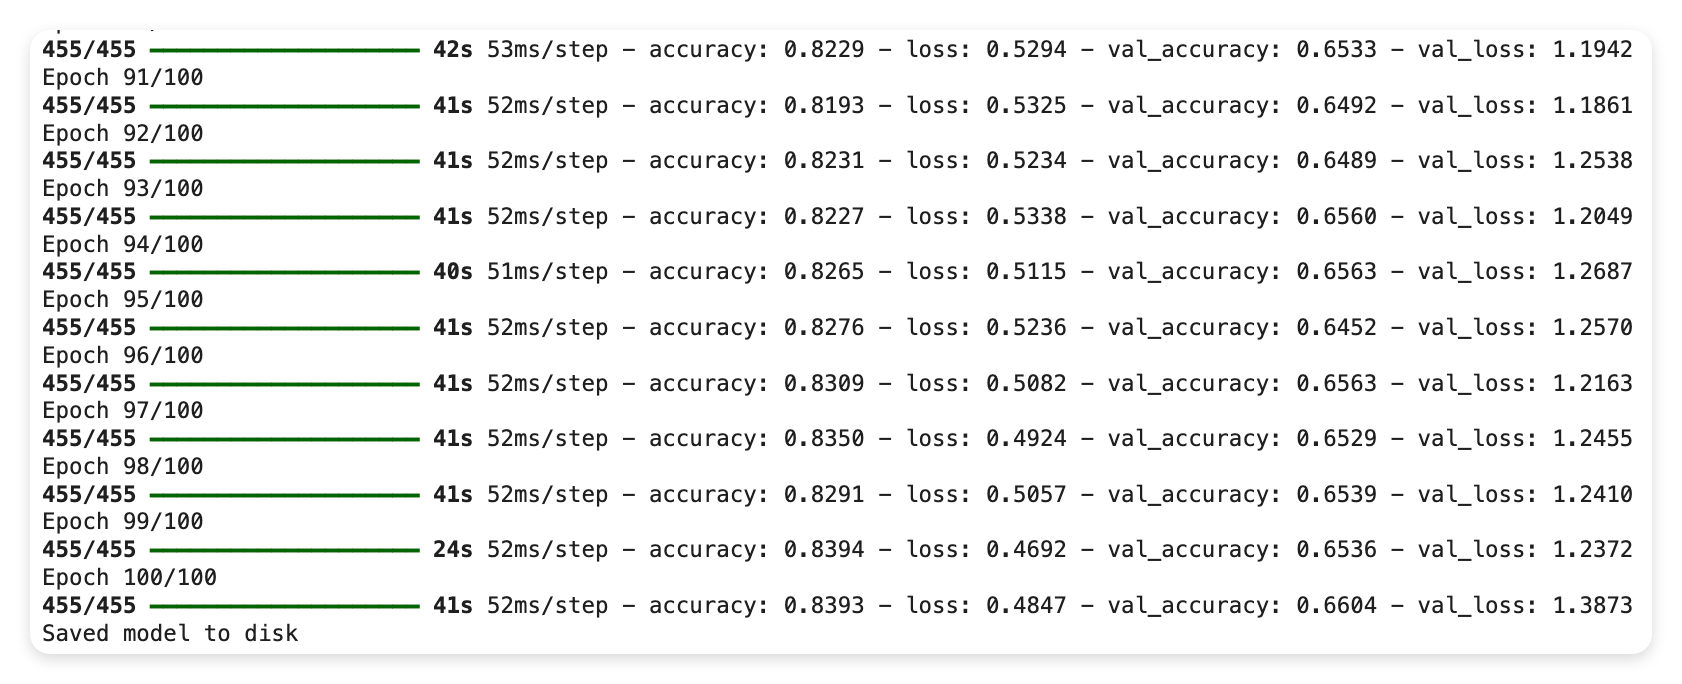

## Test FER

In [6]:
from keras.models import model_from_json, Sequential

pathname = '/content/drive/MyDrive/FIT3162/deep-lie/fer2013/'

# reads a model and its weights stored at path as name of file
# with .json for model and .h5 for weights
def load_model(path = pathname, file='fer'):
  json_file = open(path+file+'.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  # load weights into new model"
  loaded_model.load_weights(path+file+'.weights.h5')
  print("Loaded model from disk")
  return loaded_model

loaded_model = load_model()

Loaded model from disk


In [ ]:
# load json and create model
from __future__ import division
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy
import os
import numpy as np

json_file = open(pathname+'fer.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(pathname+"fer.weights.h5")
print("Loaded model from disk")

truey=[]
predy=[]
x = np.load(pathname+'modXtest.npy')
y = np.load(pathname+'modytest.npy')

yhat= loaded_model.predict(x)
yh = yhat.tolist()
yt = y.tolist()
count = 0

for i in range(len(y)):
    yy = max(yh[i])
    yyt = max(yt[i])
    predy.append(yh[i].index(yy))
    truey.append(yt[i].index(yyt))
    if(yh[i].index(yy)== yt[i].index(yyt)):
        count+=1

acc = (count/len(y))*100

#saving values for confusion matrix and analysis
np.save(pathname+'truey', truey)
np.save(pathname+'predy', predy)
print("Predicted and true label values saved")
print("Accuracy on test set :"+str(acc)+"%")


Loaded model from disk
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step
Predicted and true label values saved
Accuracy on test set :63.945388687656724%


### Custom Test

Loaded model from disk
Image Loaded
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
Emotion: Neutral


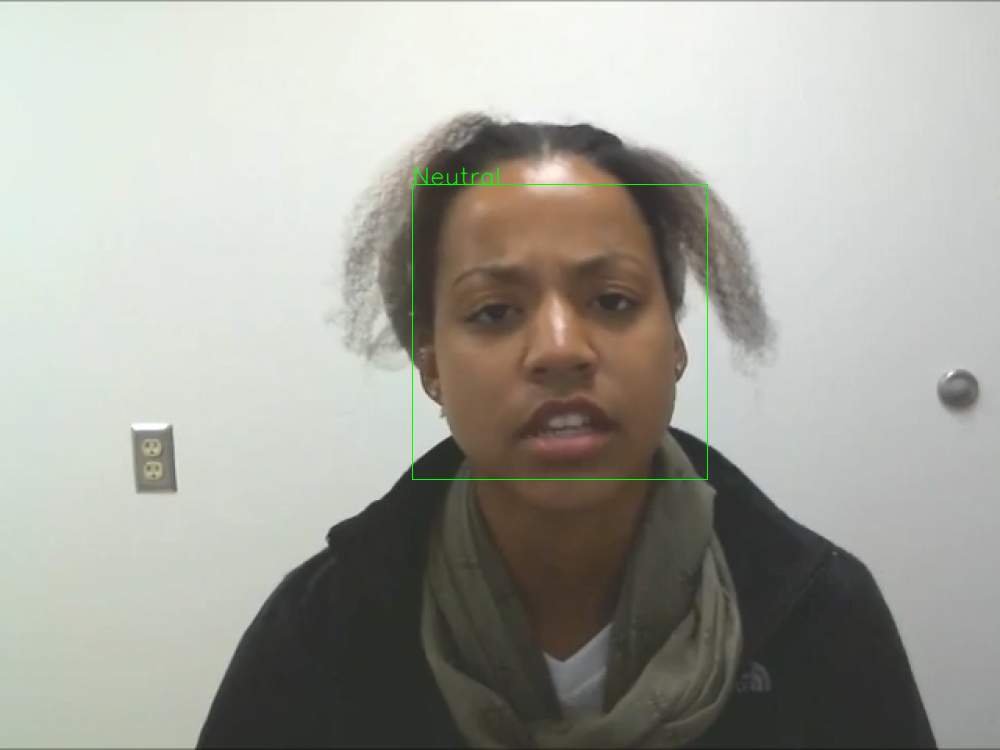

-1

In [ ]:
# load json and create model
from __future__ import division
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

#loading the model
json_file = open(pathname+'fer.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(pathname+"fer.weights.h5")
print("Loaded model from disk")

#setting image resizing parameters
WIDTH = 48
HEIGHT = 48
x=None
y=None
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

#loading image
test_path=pathname + 'Test Images/'
full_size_image = cv2.imread(test_path+'test.png')
full_size_image = image_resize(full_size_image, width=1000)
print("Image Loaded")
gray=cv2.cvtColor(full_size_image,cv2.COLOR_RGB2GRAY)
face = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face.detectMultiScale(gray, 1.3, 5)

#detecting faces
for (x, y, w, h) in faces:
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
        cv2.rectangle(full_size_image, (x, y), (x + w, y + h), (0, 255, 0), 1)
        #predicting the emotion
        yhat= loaded_model.predict(cropped_img)
        cv2.putText(full_size_image, labels[int(np.argmax(yhat))], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 1, cv2.LINE_AA)
        print("Emotion: "+labels[int(np.argmax(yhat))])

cv2_imshow(full_size_image)
cv2.waitKey()


# Download datasets

In [9]:
import shutil
import os

def unzipAndReplace(folder_path, zip_path):
  if os.path.exists(folder_path):

    # Remove the directory and all its contents
    shutil.rmtree(folder_path)
    print(f"Directory '{folder_path}' and all its contents have been removed.")

  else:
      print(f"Directory '{folder_path}' does not exist.")

  !unzip -q "dataset_300_retina_face.zip"
  print("Done unzip")

## Download MU3D videos

In [ ]:
!gdown "https://drive.google.com/file/d/16wsovxe4EDGPBlz1t28xOq20s-vInEN7/view?usp=drive_link" --fuzzy

Downloading...
From (original): https://drive.google.com/uc?id=16wsovxe4EDGPBlz1t28xOq20s-vInEN7
From (redirected): https://drive.google.com/uc?id=16wsovxe4EDGPBlz1t28xOq20s-vInEN7&confirm=t&uuid=62df9d0a-1743-4f71-a9fd-c2ef34fe31f4
To: /content/Videos-20250304T061900Z-001.zip
100% 1.65G/1.65G [00:17<00:00, 91.8MB/s]


Delete ./Videos

In [ ]:
unzipAndReplace("./Videos", "Videos-20250304T061900Z-001.zip")

## Download preprocessed MU3D video frames (300/sample)

In [28]:
!gdown "https://drive.google.com/file/d/1J73GPv7zC2rXq7rtMz7XgNPX2CIfQvjx/view?usp=drive_link" --fuzzy

Downloading...
From (original): https://drive.google.com/uc?id=1J73GPv7zC2rXq7rtMz7XgNPX2CIfQvjx
From (redirected): https://drive.google.com/uc?id=1J73GPv7zC2rXq7rtMz7XgNPX2CIfQvjx&confirm=t&uuid=8d2cec7e-d076-4bd4-987b-18d0eed06be2
To: /content/dataset_300_retina_face.zip
100% 2.29G/2.29G [00:33<00:00, 68.9MB/s]


In [29]:
unzipAndReplace("./dataset_300_3_points", "dataset_300_retina_face.zip")

Directory './dataset_300_3_points' and all its contents have been removed.
Done unzip


# Part 2: Lie Detection in Video

To calculate confusion matrix:

In [30]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels = ['deceptive', 'truthful'], title='Confusion Matrix'):
  cm = confusion_matrix(y_true, y_pred)
  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation=45)
  plt.yticks(tick_marks, labels)
  fmt = 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()
  plt.show()

Define paths to be used later

In [31]:
import pandas as pd

# define paths
drive_path = '/content/drive/MyDrive/FIT3162/deep-lie/'
video_path = "/content/Videos/"
frames_path_300 = "/content/dataset_300_3_points/"
project_path = drive_path + "Project/"
video_dir_path = project_path + "MU3D Codebook.xlsx"

Create a video dictionary to map IDs to labels

In [32]:
video_data = pd.read_excel(video_dir_path, sheet_name='Video-Level Data')

video_filenames = video_data['VideoID'].tolist()
labels = video_data['Veracity'].tolist()

video_dict = dict(zip(video_filenames, labels))
print(video_dict)

{'BF001_1PT': 1, 'BF001_2NL': 0, 'BF001_3NT': 1, 'BF001_4PL': 0, 'BF002_1PT': 1, 'BF002_2NL': 0, 'BF002_3NT': 1, 'BF002_4PL': 0, 'BF003_1PT': 1, 'BF003_2NL': 0, 'BF003_3NT': 1, 'BF003_4PL': 0, 'BF004_1PT': 1, 'BF004_2NL': 0, 'BF004_3NT': 1, 'BF004_4PL': 0, 'BF006_1PT': 1, 'BF006_2NL': 0, 'BF006_3NT': 1, 'BF006_4PL': 0, 'BF008_1PT': 1, 'BF008_2NL': 0, 'BF008_3NT': 1, 'BF008_4PL': 0, 'BF013_1PT': 1, 'BF013_2NL': 0, 'BF013_3NT': 1, 'BF013_4PL': 0, 'BF014_1PT': 1, 'BF014_2NL': 0, 'BF014_3NT': 1, 'BF014_4PL': 0, 'BF015_1PT': 1, 'BF015_2NL': 0, 'BF015_3NT': 1, 'BF015_4PL': 0, 'BF016_1PT': 1, 'BF016_2NL': 0, 'BF016_3NT': 1, 'BF016_4PL': 0, 'BF018_1PT': 1, 'BF018_2NL': 0, 'BF018_3NT': 1, 'BF018_4PL': 0, 'BF019_1PT': 1, 'BF019_2NL': 0, 'BF019_3NT': 1, 'BF019_4PL': 0, 'BF020_1PT': 1, 'BF020_2NL': 0, 'BF020_3NT': 1, 'BF020_4PL': 0, 'BF022_1PT': 1, 'BF022_2NL': 0, 'BF022_3NT': 1, 'BF022_4PL': 0, 'BF023_1PT': 1, 'BF023_2NL': 0, 'BF023_3NT': 1, 'BF023_4PL': 0, 'BF024_1PT': 1, 'BF024_2NL': 0, 'BF024_

### Some helper functions and one-time read / write operations (don't worry about it)
Define function to create paths, read and process videos

In [33]:
def create_path(path):
  try:
    if not os.path.exists(path):
      os.makedirs(path)
  except OSError:
    print(f"Error: Creating directory: {path}")

In [16]:
from alive_progress import alive_bar
from google.colab import output
output.enable_custom_widget_manager()

def preprocess_image(img):
  gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # we turn the image to grayscale
  cropped_img = np.expand_dims(np.expand_dims(cv2.resize(gray_img, (48, 48)), -1), 0)
  cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
  return cropped_img

# Using the 300 frames dataset
# Saves the cropped facial image
def read_video_300(filename):
    folder = os.path.join(frames_path_300, filename)
    frame_files = sorted(os.listdir(folder))

    # Initialize an array to store the flattened cropped images for 300 frames
    xdata = np.zeros((300, 48*48))
    frame_count = 0

    for frame_file in frame_files:
        if frame_count >= 300: break # limit the max number of frames we examine

        frame_path = os.path.join(folder, frame_file)
        frame_image = cv2.imread(frame_path)

        if frame_image is None: continue # skip frames cannot be loaded

        # Preprocess and flatten
        cropped_img = preprocess_image (frame_image) # resize/normalize to 48x48
        xdata[frame_count, :] = cropped_img.flatten()
        frame_count += 1

    # Release all space and windows once done
    cv2.destroyAllWindows()

    return xdata

def saveData(X, y):
  X = np.asarray(X)
  y = np.asarray(y)
  np.save(project_path+'fdataX', X)
  np.save(project_path+'flabels', y)


X = []
y = []

count = 0
with alive_bar(len(video_dict), force_tty=True) as bar:

  for (k, v) in video_dict.items():
    count+=1
    xi = read_video_300(k)
    X.append(xi)
    y.append(v)
    if count % 5 == 0:
      saveData(X, y)
    bar()

saveData(X, y)
print(f"\nComplete saving {count} number of data")


|████████████████████████████████████████| 320/320 [100%] in 4:14.9 (1.25/s)    

Complete saving 320 number of data


Visualise the dataset

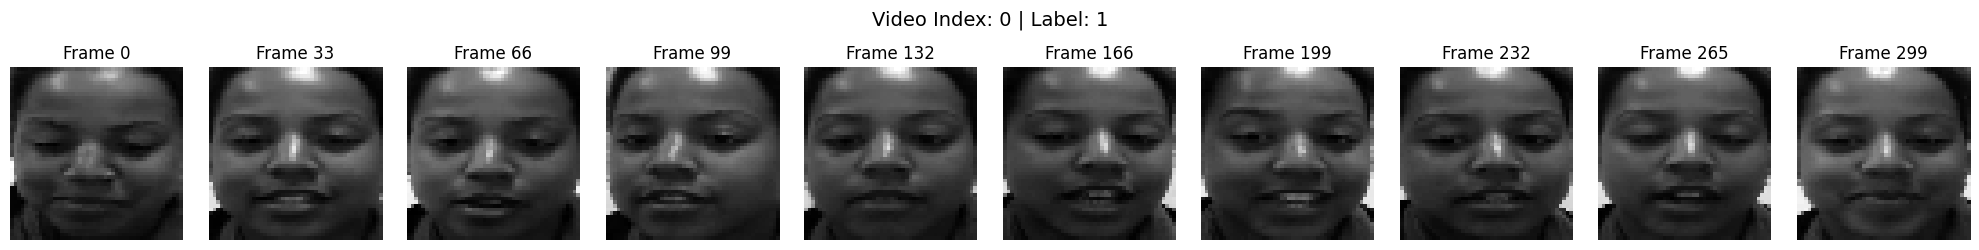

In [34]:
import numpy as np
import matplotlib.pyplot as plt

X = np.load(project_path + 'fdataX.npy')  # shape: (num_videos, 300, 48*48)
y = np.load(project_path + 'flabels.npy') # shape: (num_videos,)

def display_video_sample(video_index, num_frames=10):
    """
    Displays num_frames (evenly spaced) from the video sample at video_index.
    """
    # Get the video sample and its corresponding label
    video_data = X[video_index]  # shape: (300, 48*48)
    label = y[video_index]

    # Choose evenly spaced indices to display frames
    indices = np.linspace(0, video_data.shape[0] - 1, num_frames, dtype=int)

    # Create a figure with subplots
    fig, axs = plt.subplots(1, num_frames, figsize=(num_frames*2, 2.5))
    fig.suptitle(f"Video Index: {video_index} | Label: {label}", fontsize=14)

    # Iterate over selected frame indices and plot each frame
    for i, idx in enumerate(indices):
        frame = video_data[idx].reshape(48, 48)  # reshape from flattened to 48x48
        axs[i].imshow(frame, cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(f"Frame {idx}")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Example: Display sample frames for the first video (index 0)
display_video_sample(0)

## Train DNN

In [35]:
import sys, os
import pandas as pd
import numpy as np

from tensorflow.keras import initializers
from keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Masking, GRU
from keras.layers import Conv1D, Conv2D, Conv3D, MaxPooling1D, MaxPooling2D, MaxPooling3D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.models import model_from_json
import tensorflow as tf
import matplotlib.pyplot as plt

In [36]:
X = np.load(project_path+'fdataX.npy')
y = np.load(project_path+'flabels.npy')

print('Loaded data', X.shape, y.shape)

Loaded data (320, 300, 2304) (320,)


In [37]:
X = np.reshape(X,(X.shape[0], X.shape[1], 48, 48))
X = np.expand_dims(X, -1)
X.shape

(320, 300, 48, 48, 1)

### Gated Recurrent Units (GRU) Model

In [40]:
from alive_progress import alive_bar
from google.colab import output
output.enable_custom_widget_manager()

# load the layers from the pre-trained, loaded model
layer_names = [layer.name for layer in loaded_model.layers]
layer_outputs = [layer.output for layer in loaded_model.layers]
print(f"layer_names total: {len(layer_names)}")

# pre-process input X
X -= np.mean(X, axis=0)
X /= (np.std(X, axis=0) + 1e-8)

# for each entry, we will convert each of the 300 images (48, 48, 1) to encoding vectors
encoding_model = Model(inputs = loaded_model.inputs, outputs = layer_outputs[23])

X_cnn = np.zeros((X.shape[0], X.shape[1], 4608))
i = 0
with alive_bar(len(X), force_tty=True) as bar:
  for (xi, yi) in zip(X, y):
    predictedX = encoding_model.predict(xi, verbose=0)
    X_cnn[i] = predictedX
    i+=1
    bar()

#splitting into training, validation and testing data
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y, test_size=0.1, random_state=1) # random_state=42
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=7) # random_state=41

#saving the test samples to be used later
np.save(project_path+'modXtest', X_test)
np.save(project_path+'modytest', y_test)


layer_names total: 31
|████████████████████████████████████████| 320/320 [100%] in 38.1s (8.39/s)     


Visualise the encoded training data

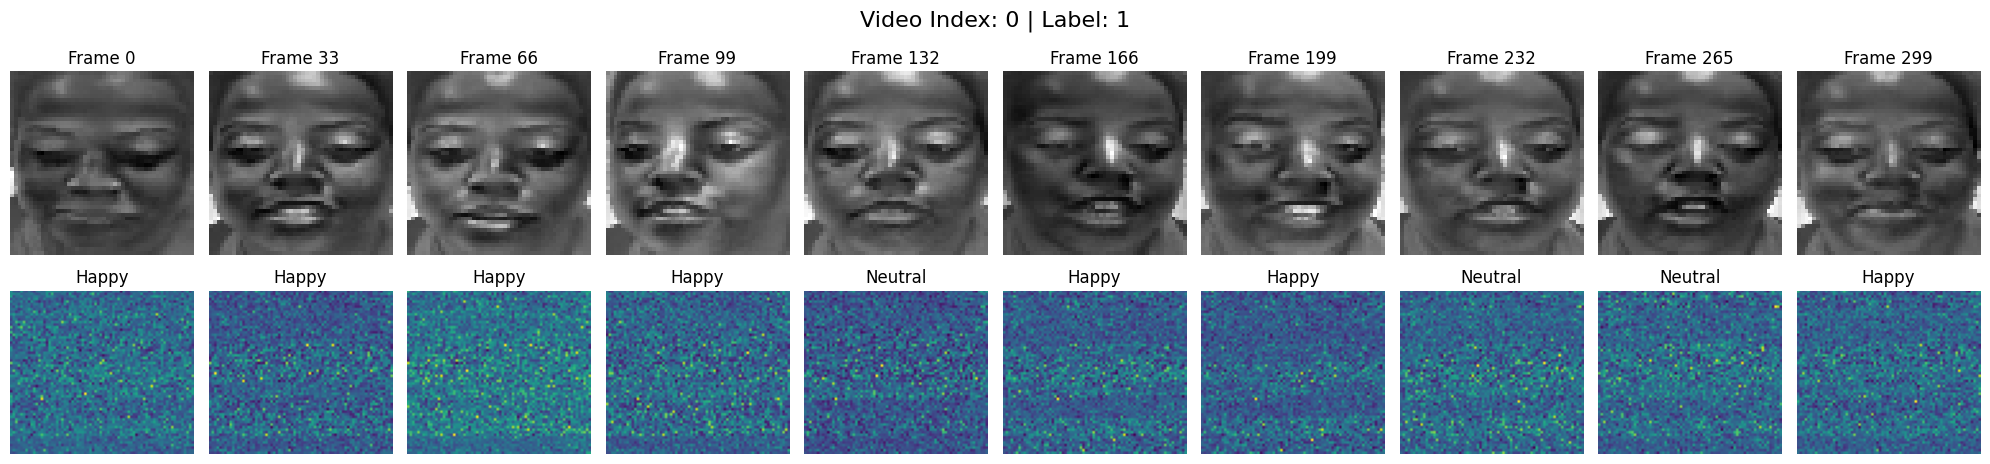

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

label_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def predict_expression(frame_48x48):
    """
    Predicts the facial expression using the loaded FER model.
    'frame_48x48' should be a 48x48 grayscale image (float32).
    Returns a string label for the top predicted emotion.
    """
    # Model expects (batch_size, 48, 48, 1) if that's how it was trained.
    # Expand dims to create batch and channel dimension.
    input_batch = np.expand_dims(frame_48x48, axis=-1)  # (48,48) -> (48,48,1)
    input_batch = np.expand_dims(input_batch, axis=0)   # -> (1,48,48,1)

    # Predict probabilities for each of the 7 classes
    probs = loaded_model.predict(input_batch, verbose=0)[0]  # shape (7,)
    top_idx = np.argmax(probs)
    return label_names[top_idx]

def display_video_with_encoding(video_index, num_frames=10):
    """
    Displays a sample video with:
      - Top row: Original frames (48x48) + predicted expression in title
      - Bottom row: Encoding heatmaps (reshaped to 64x72)
    """
    # Retrieve the video sample (300 frames) and its encoding
    video_frames = X[video_index]      # shape: (300, 48*48)
    encodings = X_cnn[video_index]     # shape: (300, 4608)

    # If y is one-hot or multi-hot, you can decode it;
    # otherwise, this might be an integer or string label already.
    # Here we just show the raw label as an example:
    raw_label = y[video_index]

    # Evenly spaced frame indices
    indices = np.linspace(0, video_frames.shape[0] - 1, num_frames, dtype=int)

    # Create a figure with two rows
    fig, axs = plt.subplots(2, num_frames, figsize=(num_frames*2, 5))
    fig.suptitle(f"Video Index: {video_index} | Label: {raw_label}", fontsize=16)

    for j, idx in enumerate(indices):
        # ----------------------------
        # TOP ROW: Original frame
        # ----------------------------
        # Convert flattened 48*48 to (48,48)
        frame_2d = video_frames[idx].reshape(48, 48).astype('float32')

        axs[0, j].imshow(frame_2d, cmap='gray')
        axs[0, j].axis('off')
        axs[0, j].set_title(f"Frame {idx}")

        # ----------------------------
        # BOTTOM ROW: Encoding heatmap
        # ----------------------------
        encoding_frame = encodings[idx].reshape(64, 72)
        # Predict the expression using the loaded FER model
        predicted_expr = predict_expression(frame_2d)
        im = axs[1, j].imshow(encoding_frame, cmap='viridis')
        axs[1, j].axis('off')
        axs[1, j].set_title(f"{predicted_expr}")


    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()

display_video_with_encoding(0)


In [45]:
print(X_train.shape, y_train.shape)
m = X_train.shape[0]
Tx = X_train.shape[1]
dims = X_train.shape[2]

(259, 300, 4608) (259,)


In [50]:

# train a GRU network for binary classification
def create_gru_model(input_shape):
  X_input = Input(shape=input_shape)
  X = Conv1D(filters=196, kernel_size=15, strides=4)(X_input) #filters = 196, kernel_size = 15
  X = MaxPooling1D(pool_size=30, strides=15, padding='same')(X) # pool 30, strides 15 is fine!
  X = BatchNormalization()(X)
  X = Activation("relu")(X)
  X = Dropout(rate=0.8)(X)

  X = GRU(units=128, return_sequences=True)(X)
  X = Dropout(rate=0.8)(X)
  X = BatchNormalization()(X)

  # X = GRU(units=128, return_sequences=True)(X)
  X = GRU(units=128, return_sequences=False)(X)
  X = Dropout(rate=0.8)(X)
  X = BatchNormalization()(X)

  X = Dropout(rate=0.8)(X) #0.8 is fine!

  X = Dense(1, activation="sigmoid")(X)

  model = Model(inputs=X_input, outputs=X)

  return model

gru_model = create_gru_model(input_shape=(Tx, dims))
gru_model.summary()

Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 300, 4608)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 72, 196)             │      13,547,716 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 5, 196)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 5, 196)              │             784 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 5, 196)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 5, 196)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_14 (GRU)                         │ (None, 5, 128)              │         125,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 5, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 5, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_15 (GRU)                         │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,773,909 (52.54 MB)

 Trainable params: 13,773,005 (52.54 MB)

 Non-trainable params: 904 (3.53 KB)

In [30]:
print(np.array(X_train).shape)
print(np.array(y_train).shape)

(259, 300, 4608)
(259,)


In [52]:
gru_model.compile(loss='binary_crossentropy', optimizer=Adam(
    learning_rate=0.001, # 0.001
    beta_1=0.9,
    beta_2=0.999,
    decay=0.01,  # 0.01
    epsilon=1e-7
  ), metrics=['accuracy'])

gru_model.fit(np.array(X_train), np.array(y_train),
          batch_size=64,
          epochs=150,
          verbose=1,
          validation_data=(np.array(X_valid), np.array(y_valid)),
          shuffle=True,
  )


# evaluate the keras model
_, accuracy = gru_model.evaluate(X_valid, y_valid)
acc_str = '%.2f' % (accuracy*100)
print(f'Accuracy: {acc_str}%')


#saving the  model to be used later
folder_path = "gru_model/"

gru_model_json = gru_model.to_json()
with open(project_path+folder_path+"gru_model_"+acc_str+".json", "w") as json_file:
    json_file.write(gru_model_json)
gru_model.save_weights(project_path+folder_path+"gru_model_"+acc_str+".weights.h5")
print("Saved gru_model to disk")

Epoch 1/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 409ms/step - accuracy: 0.5389 - loss: 1.2698 - val_accuracy: 0.4828 - val_loss: 0.7768
Epoch 2/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.4820 - loss: 1.5628 - val_accuracy: 0.5172 - val_loss: 0.7850
Epoch 3/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.4707 - loss: 1.3324 - val_accuracy: 0.4828 - val_loss: 0.8181
Epoch 4/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.4755 - loss: 1.3310 - val_accuracy: 0.5172 - val_loss: 0.8376
Epoch 5/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.4833 - loss: 1.4112 - val_accuracy: 0.4828 - val_loss: 0.8401
Epoch 6/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - accuracy: 0.5361 - loss: 1.4150 - val_accuracy: 0.4828 - val_loss: 0.8465
Epoch 7/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - accuracy: 0.4928 - loss: 1.3431 - val_accuracy: 0.4828 - val_loss: 0.8365
Epoch 8/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.5031 - loss: 1.2641 - val_accuracy: 0.5172 - v

**Model outputs**
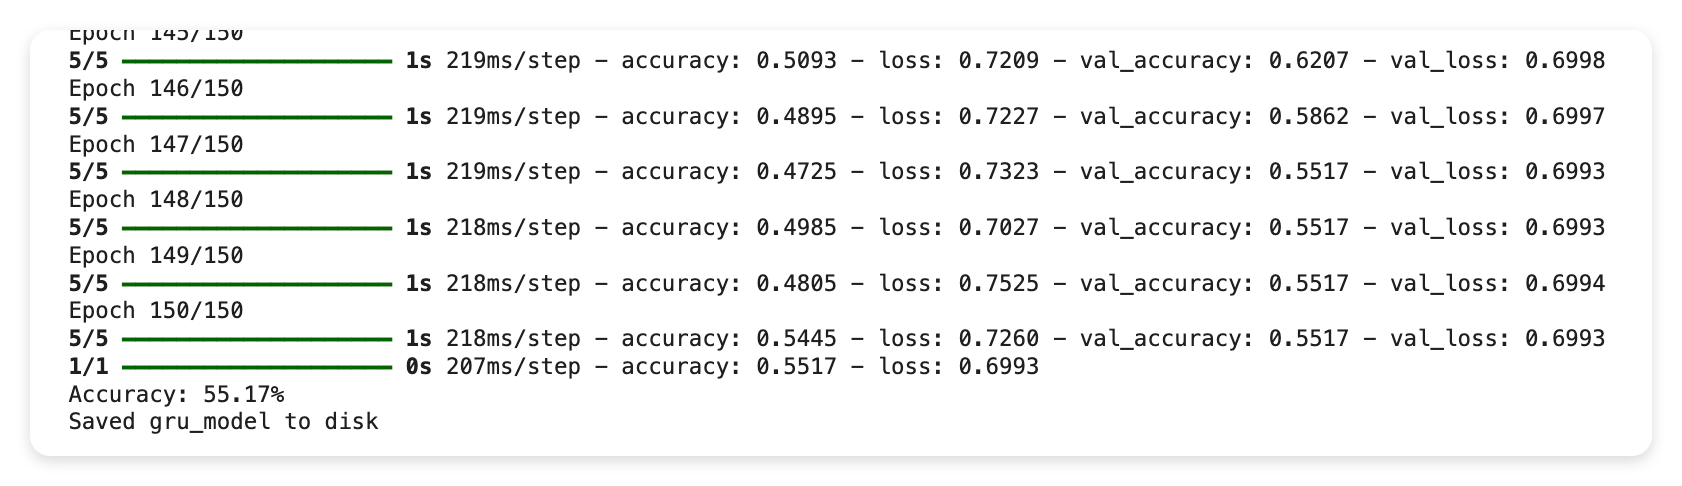

#### Leave-one-out cross validation evaluation

According to "Video Based Deception Detection Using Deep Recurrent Convolutional Neural Network" (CVIP 2019) by Sushma Venkatesh, Raghavendra Ramachandra, Patrick Bours, using Leave-one-out cross validation across 25 trials, they have achieved 100% accuracy on the same dataset (121 trial videos) using Deep Recurrent Convolutional Neural Network.

In [ ]:
import numpy as np
from sklearn.model_selection import LeaveOneOut
# X = np.array([[1, 2], [3, 4]])
# y = np.array([1, 2])
loo = LeaveOneOut()
loo.get_n_splits(X)
print(loo)

acc_per_trial = []
loss_per_trial = []

trial = 0
for train_index, test_index in loo.split(X_cnn):
    trial += 1
    X_train, X_valid = X_cnn[train_index], X_cnn[test_index]
    y_train, y_valid = y[train_index], y[test_index]

    gru_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, decay=0.01, epsilon=1e-7), metrics=['accuracy'])
    history = gru_model.fit(np.array(X_train), np.array(y_train),
              batch_size=64,
              epochs=200, # 150
              verbose=1,
              validation_data=(np.array(X_valid), np.array(y_valid)),
              shuffle=True)
    scores = gru_model.evaluate(X_valid, y_valid, verbose=0)
    print(f'Score for trial {trial}: {gru_model.metrics_names[0]} of {scores[0]}; {gru_model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_trial.append(scores[1] * 100)
    loss_per_trial.append(scores[0])


    # evaluate the keras model
    _, accuracy = gru_model.evaluate(X_valid, y_valid)
    acc_str = '%.2f' % (accuracy*100)
    print(f'Accuracy: {acc_str}%')

    if trial == 25: break # we only look at 25 trials



print('------------------------------------------------------------------------')
print('Score per trial')
for i in range(0, len(acc_per_trial)):
  print('------------------------------------------------------------------------')
  print(f'> Trial {i+1} - Loss: {loss_per_trial[i]} - Accuracy: {acc_per_trial[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all trial:')
acc_str = f'{np.mean(acc_per_trial)} (+- {np.std(acc_per_trial)})'
print(f'> Accuracy: {acc_str})')
print(f'> Loss: {np.mean(loss_per_trial)}')
print('------------------------------------------------------------------------')

folder_path = 'gru_model/'
loocv_gru_path = os.path.join(project_path, folder_path)
gru_model.save_weights(project_path+folder_path+"gru_model_(LOOCV)_"+acc_str+".weights.h5")

print(f"Scores and weights saved to: {folder_path}")

Streaming output truncated to the last 5000 lines.
Epoch 149/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.9936 - loss: 0.0178 - val_accuracy: 1.0000 - val_loss: 2.1219e-08
Epoch 150/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - accuracy: 0.9858 - loss: 0.0191 - val_accuracy: 1.0000 - val_loss: 1.8624e-08
Epoch 151/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - accuracy: 0.9961 - loss: 0.0051 - val_accuracy: 1.0000 - val_loss: 1.7144e-08
Epoch 152/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - accuracy: 0.9910 - loss: 0.0148 - val_accuracy: 1.0000 - val_loss: 1.4590e-08
Epoch 153/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.9785 - loss: 0.0305 - val_accuracy: 1.0000 - val_loss: 1.3475e-08
Epoch 154/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.9886 - loss: 0.0156 - val_accuracy: 1.0000 - val_loss: 1.2074e-08
Epoch 155/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - accuracy: 0.9979 - loss: 0.0054 - val_accuracy: 1.0000 - val_loss: 1.1042e-08
Epoch 156/200
5/5 

#### Siamese Network with Triplet Loss for Classification

First we generate dataset for the triplet loss.

Then we train a 2-layer GRU model to output a 128-dim encoding vector for each preprocessed video input.

Finally, we store the average encoding vector for positive and negative classes for later use.



---



Whenever there is a new video, we simply

1) get the preprocessed video as a vector

2) compare the distance(average_positive_encoding, video_encoding) vs. distance(average_negative_encoding, video_encoding) to assign a label 0 or 1.

In [41]:
# Data preprocessing
X_train = X_train.reshape(X_train.shape[0], 300, 4608)
print(X_train.shape, y_train.shape)
input_shape = X_train.shape[1:]
print(f"input_shape={input_shape}")

X_valid = X_valid.reshape(X_valid.shape[0], 300, 4608)

(259, 300, 4608) (259,)
input_shape=(300, 4608)


In [42]:
import random

# Returns a list of randomly generated anchors, positives and negatives
# of size batch_size (default to 5000)
def create_batch(batch_size=5000):
    x_anchors = np.zeros((batch_size, 300, 4608))
    x_positives = np.zeros((batch_size, 300, 4608))
    x_negatives = np.zeros((batch_size, 300, 4608))

    for i in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, X_train.shape[0] - 1)
        x_anchor = X_train[random_index]
        y = y_train[random_index]

        indices_for_pos = np.squeeze(np.where(y_train == y))
        indices_for_neg = np.squeeze(np.where(y_train != y))

        x_positive = X_train[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        x_negative = X_train[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]

        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative

    return [x_anchors, x_positives, x_negatives]

In [46]:
emb_size = 64

def create_embedding_model(input_shape):
  X_input = Input(shape=input_shape)
  X = Conv1D(filters=196, kernel_size=15, strides=4)(X_input) #filters = 196, kernel_size = 15
  # X = MaxPooling1D(pool_size=15)(X)
  X = MaxPooling1D(pool_size=30, strides=15, padding='valid')(X) # pool 30, strides 15 is fine!
  X = BatchNormalization()(X)
  X = Activation("relu")(X)
  X = Dropout(rate=0.8)(X)

  X = GRU(units=128, return_sequences=True)(X)
  X = Dropout(rate=0.8)(X)
  X = BatchNormalization()(X)

  X = GRU(units=128, return_sequences=True)(X)
  X = Dropout(rate=0.8)(X)
  X = BatchNormalization()(X)

  X = Dropout(rate=0.5)(X) #0.8 is fine!

  X = Flatten()(X)
  X = Dense(emb_size, activation="sigmoid")(X)

  model = Model(inputs=X_input, outputs=X)

  return model

embedding_model=create_embedding_model(input_shape=(Tx, dims))
embedding_model.summary()

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 300, 4608)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 72, 196)             │      13,547,716 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 3, 196)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 3, 196)              │             784 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 3, 196)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3, 196)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 3, 128)              │         125,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 3, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 3, 128)              │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 3, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          24,640 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,798,420 (52.64 MB)

 Trainable params: 13,797,516 (52.63 MB)

 Non-trainable params: 904 (3.53 KB)

In [47]:
# Siamese Network

input_anchor = Input(shape=(Tx, dims,))
input_positive = Input(shape=(Tx, dims,))
input_negative = Input(shape=(Tx, dims,))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)

net = tf.keras.models.Model([input_anchor, input_positive, input_negative], output)
net.summary()

Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 300, 4608)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 300, 4608)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 300, 4608)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_35             │ (None, 64)             │     13,798,420 │ input_layer_1[0][0],   │
│ (Functional)              │                        │                │ input_layer_2[0][0],   │
│                           │                        │                │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 192)            │              0 │ functional_35[0][0],   │
│                           │                        │                │ functional_35[1][0],   │
│                           │                        │                │ functional_35[2][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 13,798,420 (52.64 MB)

 Trainable params: 13,797,516 (52.63 MB)

 Non-trainable params: 904 (3.53 KB)

In [48]:
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA

# we will use this function to visualize how the embedding model is doing over time.
class PCAPlotter(tf.keras.callbacks.Callback):

    def __init__(self, plt, embedding_model, x_test, y_test):
        super(PCAPlotter, self).__init__()
        self.embedding_model = embedding_model
        self.x_test = x_test
        self.y_test = y_test
        self.fig = plt.figure(figsize=(9, 4))
        self.ax1 = plt.subplot(1, 2, 1)
        self.ax2 = plt.subplot(1, 2, 2)
        plt.ion()

        self.losses = []

    def plot(self, epoch=None, plot_loss=False):
        x_test_embeddings = self.embedding_model.predict(self.x_test)
        pca_out = PCA(n_components=2).fit_transform(x_test_embeddings)
        self.ax1.clear()
        self.ax1.scatter(pca_out[:, 0], pca_out[:, 1], c=self.y_test, cmap='seismic')
        if plot_loss:
            self.ax2.clear()
            self.ax2.plot(range(epoch), self.losses)
            self.ax2.set_xlabel('Epochs')
            self.ax2.set_ylabel('Loss')
        self.fig.canvas.draw()

    def on_train_begin(self, logs=None):
        self.losses = []
        self.fig.show()
        self.fig.canvas.draw()
        self.plot()

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs.get('loss'))
        self.plot(epoch+1, plot_loss=True)

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - loss: 0.2006
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1998
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.2000
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.1954
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.2002
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.1972
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.1993
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.2001
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.1978
Epoch 10/100
1/1 ━━━━━━━━━━━━━

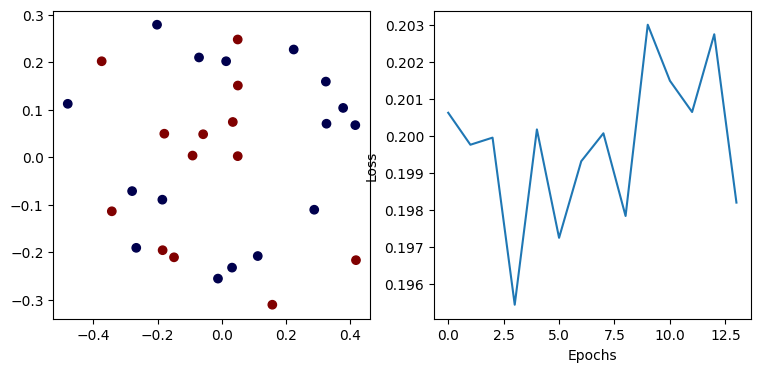

In [49]:
# Triplet Loss

alpha = 0.2 # 0.6 was fine

def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

# Data Generator

def data_generator(batch_size=64):
    while True:
        x = create_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_size))
        yield tuple(x), y

# Model Training
batch_size = m
epochs = 100 #int(400000/m/100)
steps_per_epoch = int(m/batch_size)

net.compile(loss=triplet_loss, optimizer=Adam(learning_rate=3e-4, beta_1=0.9, beta_2=0.999, decay=0.01, epsilon=1e-7))


# early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)


_ = net.fit(
    data_generator(batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs, verbose=True,
    callbacks=[
        early_stopping_callback,
        PCAPlotter(
            plt, embedding_model,
            X_valid[:1000], y_valid[:1000]
        )]
)

In [50]:
# we need to store the average truth vector
# and the average lie vector learned
# with training set for verify
X_train_emb = embedding_model.predict(X_train)

truth_emb = []
lie_emb = []
for xi, yi in zip(X_train_emb, y_train):
  if yi == 1:
    truth_emb.append(xi)
  else:
    lie_emb.append(xi)
print(f"There are {len(truth_emb)} truths and {len(lie_emb)} lies.")

average_truth_emb = np.mean(truth_emb, axis=0)
average_lie_emb = np.mean(lie_emb, axis=0)

database={}
database['truth'] = average_truth_emb
database['lie'] = average_lie_emb

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
There are 129 truths and 130 lies.


Next we will validate results

In [51]:
# Validation Accuracy
X_valid_emb = embedding_model.predict(X_valid)
print(f"X_valid.shape={X_valid.shape}, X_valid_emb.shape={X_valid_emb.shape}, y_valid.shape={y_valid.shape}")

# verify function: given an embedding, will tell whether or not it is truth
# based on distance from the average truth and the average lie vectors.
def verify(emb, embedding_model, database):
  dist_truth = np.linalg.norm(emb - database["truth"])
  dist_lie = np.linalg.norm(emb - database["lie"])
  print(f"dist_truth={dist_truth}, dist_lie={dist_lie}")
  return 1 if dist_truth < dist_lie  else 0


# now we measure the accuracy on validation set.
count = 0
y_pred = []

for emb, y in zip(X_valid_emb, y_valid):
  y_predict = verify(emb, embedding_model, database)
  y_pred.append(y_predict)
  if y_predict == y:
    count += 1
  else:
    print("y_predict: ", y_predict, "y: ", y)


accuracy = count/X_valid_emb.shape[0]
acc_str = '%.2f' % (accuracy*100)
print('Validation Accuracy: '+acc_str+'%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
X_valid.shape=(29, 300, 4608), X_valid_emb.shape=(29, 64), y_valid.shape=(29,)
dist_truth=0.18820466101169586, dist_lie=0.1847376674413681
y_predict:  0 y:  1
dist_truth=0.2433662861585617, dist_lie=0.25899556279182434
y_predict:  1 y:  0
dist_truth=0.30025020241737366, dist_lie=0.2882433533668518
dist_truth=0.26663854718208313, dist_lie=0.2599743604660034
dist_truth=0.30703282356262207, dist_lie=0.29885268211364746
dist_truth=0.3966037631034851, dist_lie=0.3918764889240265
dist_truth=0.4686795473098755, dist_lie=0.453168660402298
y_predict:  0 y:  1
dist_truth=0.32949554920196533, dist_lie=0.32095637917518616
dist_truth=0.22481048107147217, dist_lie=0.20630186796188354
y_predict:  0 y:  1
dist_truth=0.26703763008117676, dist_lie=0.26288333535194397
dist_truth=0.43872395157814026, dist_lie=0.45308709144592285
y_predict:  1 y:  0
dist_truth=0.217582106590271, dist_lie=0.21586227416992188
dist_truth=0.4012228548526764, dist_lie=0.3954797089099884
di

In [52]:
# Train accuracy
X_train_emb = embedding_model.predict(X_train)
print(f"X_train.shape={X_train.shape}, X_train_emb.shape={X_train_emb.shape}, y_train.shape={y_train.shape}")

# verify function: given an embedding, will tell whether or not it is truth
# based on distance from the average truth and the average lie vectors.
def verify(emb, embedding_model, database):
  dist_truth = np.linalg.norm(emb - database["truth"])
  dist_lie = np.linalg.norm(emb - database["lie"])
  print(f"dist_truth={dist_truth}, dist_lie={dist_lie}")
  return 1 if dist_truth < dist_lie  else 0


# now we measure the accuracy on validation set.
count = 0

y_pred = []
for emb, y in zip(X_train_emb, y_train):
  y_predict = verify(emb, embedding_model, database)
  y_pred.append(y_predict)
  # print("y_predict: ", y_predict, "y: ", y)
  if y_predict == y:
    count += 1
  else:
    print("y_predict: ", y_predict, "y: ", y)

accuracy = count/X_train_emb.shape[0]
acc_str = '%.2f' % (accuracy*100)
print('Train Accuracy: '+acc_str+'%')

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
X_train.shape=(259, 300, 4608), X_train_emb.shape=(259, 64), y_train.shape=(259,)
dist_truth=0.2715870440006256, dist_lie=0.28095757961273193
dist_truth=0.27623313665390015, dist_lie=0.2875820994377136
y_predict:  1 y:  0
dist_truth=0.28447896242141724, dist_lie=0.2811916470527649
dist_truth=0.33928096294403076, dist_lie=0.3486465513706207
dist_truth=0.378391295671463, dist_lie=0.37742945551872253
dist_truth=0.3213973045349121, dist_lie=0.32011961936950684
dist_truth=0.3315046727657318, dist_lie=0.33970439434051514
dist_truth=0.33691084384918213, dist_lie=0.33112338185310364
y_predict:  0 y:  1
dist_truth=0.4461281895637512, dist_lie=0.4362105131149292
dist_truth=0.36963215470314026, dist_lie=0.3636176586151123
y_predict:  0 y:  1
dist_truth=0.32885095477104187, dist_lie=0.3140828311443329
dist_truth=0.35042575001716614, dist_lie=0.3559064567089081
y_predict:  1 y:  0
dist_truth=0.4445159435272217, dist_lie=0.43365782499313354
y_predict:  0 y:  1
d

[[79 51]
 [63 66]]


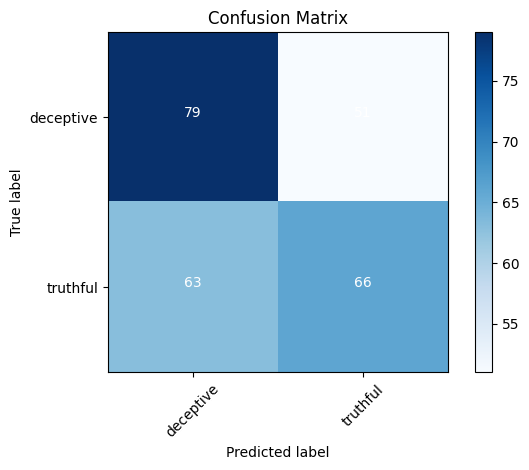

In [53]:
plot_confusion_matrix(np.array(y_train), np.array(y_pred), title='Confusion Matrix')

In [ ]:
# Predict using the model
y_pred = gru_model.predict(X_valid)

# You can then use y_pred for further analysis or evaluation
# For example, you can convert probabilities to class labels if needed
y_pred_labels = np.argmax(y_pred, axis=1)

y_pred_labels
